In [2]:
from src.system_env import System
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import cross_val_predict
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy import stats

from sklearn.semi_supervised import label_propagation

In [3]:
env = System(system_h=10, system_w=10, system_fake=0.1)
X = np.vstack((env.fake_observations, env.normal_observations))
y = np.hstack((np.zeros(env.fake_observations.shape[0]), np.ones(env.normal_observations.shape[0])))

backbone: [0, 1, 11, 21, 31, 32, 42, 52, 62, 63, 64, 65, 66, 76, 86, 87, 88, 98, 99]
fake node: [4, 13, 16, 54, 69, 92, 93, 94, 96, 97]


In [4]:
X, y = shuffle(X, y)

In [5]:
pd.DataFrame(X).describe()

,0,1
count,8.000000e+04,8.000000e+04
mean,-1.936867e-16,-1.551458e-15
std,1.868914e+00,1.499084e+00
min,-2.725518e+00,-4.732925e+00
25%,-1.984868e+00,-6.573902e-01
50%,6.469899e-01,-5.116416e-01
75%,1.654371e+00,-1.535291e-01
max,6.726038e+00,4.746936e+00


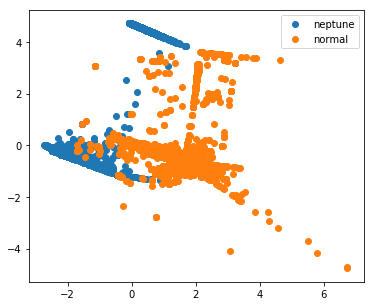

In [6]:
X_, y_ = X.copy(), y.copy()
plt.figure(figsize=(6,5))
plt.scatter(X_[y_==0,0], X_[y_==0,1], label='neptune')
plt.scatter(X_[y_==1,0], X_[y_==1,1], label='normal')
plt.legend()
plt.show()

In [7]:
X_, y_ = X[:4000], y[:4000]
n_total_samples = len(y_)
n_labeled_points = 10
max_iterations = 5

unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:]

for i in range(max_iterations):
    if len(unlabeled_indices) == 0:
        print("No unlabeled items left to label.")
        break
    y_train = np.copy(y_)
    y_train[unlabeled_indices] = -1

    lp_model = label_propagation.LabelSpreading(gamma=0.25, max_iter=5)
    lp_model.fit(X_, y_train)

    predicted_labels = lp_model.transduction_[unlabeled_indices]
    true_labels = y_[unlabeled_indices]

    cm = confusion_matrix(true_labels, predicted_labels,
                          labels=lp_model.classes_)

    print("Iteration %i %s" % (i, 70 * "_"))
    print("Label Spreading model: %d labeled & %d unlabeled (%d total)"
          % (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)

    # compute the entropies of transduced label distributions
    pred_entropies = stats.distributions.entropy(
        lp_model.label_distributions_.T)

    # select up to 5 digit examples that the classifier is most uncertain about
    uncertainty_index = np.argsort(pred_entropies)[::-1]
    delete_indices = uncertainty_index[
        np.in1d(uncertainty_index, unlabeled_indices)][:5]

    unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
    n_labeled_points += len(delete_indices)

Iteration 0 ______________________________________________________________________
Label Spreading model: 10 labeled & 3990 unlabeled (4000 total)
             precision    recall  f1-score   support

        0.0       0.97      1.00      0.99      1971
        1.0       1.00      0.97      0.99      2019

avg / total       0.99      0.99      0.99      3990

Confusion matrix
[[1966    5]
 [  53 1966]]
Iteration 1 ______________________________________________________________________
Label Spreading model: 15 labeled & 3985 unlabeled (4000 total)
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99      1969
        1.0       1.00      0.99      0.99      2016

avg / total       0.99      0.99      0.99      3985

Confusion matrix
[[1964    5]
 [  20 1996]]
Iteration 2 ______________________________________________________________________
Label Spreading model: 20 labeled & 3980 unlabeled (4000 total)
             precision    recall  f1-scor

In [8]:
clf = MLPClassifier(hidden_layer_sizes=(3,), activation='relu', solver='adam', 
                    alpha=0.01, batch_size='auto', learning_rate='constant', 
                    learning_rate_init=0.001, power_t=0.5, max_iter=2000, shuffle=True, 
                    random_state=None, tol=0.0001, verbose=False, warm_start=False, 
                    momentum=0.9, nesterovs_momentum=True, early_stopping=False, 
                    validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
sys.stdout.flush()
train_X, train_y, test_X, test_y = X[:5], y[:5], X[5:], y[5:]
clf.fit(X[:5], y[:5])
predicted = clf.predict(test_X)
print(confusion_matrix(test_y, predicted))
print(f1_score(test_y, predicted))

[[39867   130]
 [  898 39100]]
0.987024789216


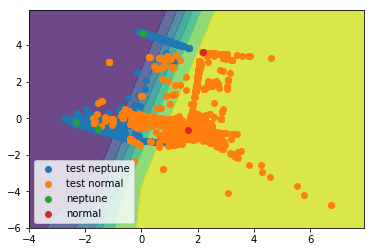

In [9]:
xx, yy = np.meshgrid(np.arange(-4, 8, 0.1),
                     np.arange(-6, 6, 0.1))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1].reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=.8)

plt.scatter(test_X[test_y==0,0], test_X[test_y==0,1], label='test neptune')
plt.scatter(test_X[test_y==1,0], test_X[test_y==1,1], label='test normal')
# plt.scatter(test_X[predicted==0,0], test_X[predicted==0,1], label='predict neptune', alpha=0.2)
# plt.scatter(test_X[predicted==1,0], test_X[predicted==1,1], label='predict normal', alpha=0.2)
plt.scatter(train_X[train_y==0,0], train_X[train_y==0,1], label='neptune')
plt.scatter(train_X[train_y==1,0], train_X[train_y==1,1], label='normal')
plt.legend()
plt.show()